## import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import os
import glob
import pandas as pd
from pathlib import Path
import seaborn as sns
sns.set()

In [2]:
data_path = Path.cwd().parent/"data"
plot_dir =  Path.cwd().parent/"plots"

In [3]:
sidelink_df = pd.read_parquet(data_path/"sidelink_dataframe.parquet")
sidelink_df = sidelink_df.assign(**{"SL3 Role": 'None'})
sidelink_df.loc[sidelink_df.syncref_source, "SL3 Role"] = "TX"
sidelink_df.loc[sidelink_df.syncref_destination, "SL3 Role"] = "RX"

In [4]:
plot_df = sidelink_df.query("`Source` != `Destination` & `SL3 Role` == 'None'")
plot_df = plot_df.assign(link=lambda x: x.Source.astype(str)+r"$\rightarrow$"+x.Destination.astype(str))

In [5]:
plot_df.columns

Index(['Source', 'Destination', 'Scenario', 'time_epoch', 'SNR', 'RSRP',
       'RSSI', 'NOISE POWER', 'RX_GAIN', 'SubFrame_NUMBER', 'SubFrame_LENGHT',
       'Rx_power', 'MCS', 'Received Packets', 'ts_gps_source',
       'Latitude_source', 'Longitude_source', 'Altitude_source',
       'speed_kmh_source', 'COG_source', 'precipIntensity_source',
       'precipProbability_source', 'temperature_source',
       'apparentTemperature_source', 'dewPoint_source', 'humidity_source',
       'pressure_source', 'windSpeed_source', 'cloudCover_source',
       'uvIndex_source', 'visibility_source', 'Traffic_Jam_Factor_source',
       'Traffic_Street_Name_source', 'Traffic_Distance_source',
       'Pos_in_Ref_Round_source', 'device_source', 'area_source',
       'ts_gps_destination', 'Latitude_destination', 'Longitude_destination',
       'Altitude_destination', 'speed_kmh_destination', 'COG_destination',
       'precipIntensity_destination', 'precipProbability_destination',
       'temperature_desti

# Plot 1 - Distance vs. PER

In [6]:
distq_df = plot_df.assign(distance_q=pd.qcut(plot_df['distance'],100, labels=False))
distq_map = distq_df[['distance','distance_q']].groupby(['distance_q']).mean()

distq_df['distance'] = distq_df['distance_q'].map(distq_map['distance'])

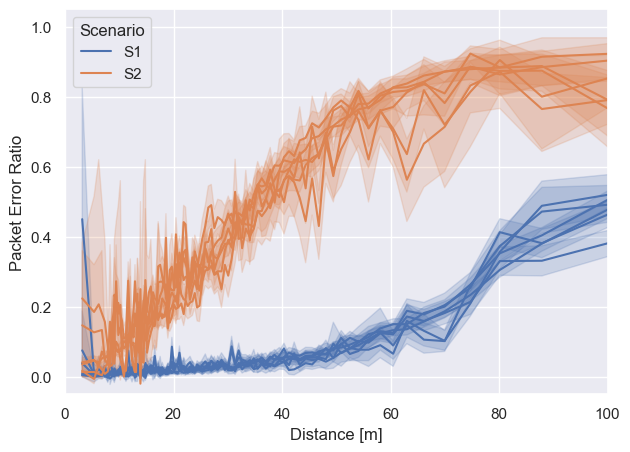

In [7]:
per_lim = (-0.05,1.05)
dist_lim = (0, 100)


ax = sns.lineplot(distq_df, x='distance', y='Packet_error_ratio', hue="Scenario",
                  style="link", dashes=[""]*6)

plt.xlabel("Distance [m]")
plt.ylabel("Packet Error Ratio")
plt.xlim(dist_lim)
plt.ylim(per_lim)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3], labels=labels[1:3], title='Scenario')

plt.gcf().set_size_inches(7, 5)
plt.savefig(plot_dir/"sl_dist_per.pdf", bbox_inches='tight')

# Plot 2 - SNR vs. PER/distance


In [8]:
snrq_df = plot_df.assign(snr_q= pd.qcut(plot_df['SNR'], 100, labels=False))
snrq_map = snrq_df[['SNR','snr_q']].groupby(['snr_q']).mean()

snrq_df['SNR'] = snrq_df['snr_q'].map(snrq_map['SNR'])

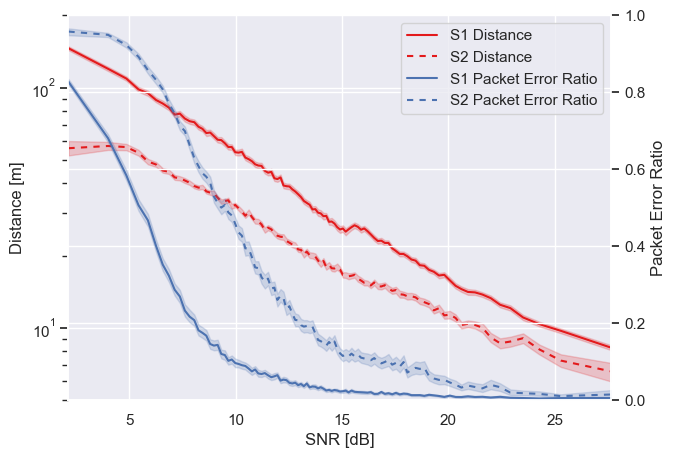

In [9]:
f = plt.figure()

dist_lim = (5,200)
per_lim = (0, 1)
snr_lim = snrq_df['SNR'].min(), snrq_df['SNR'].max()

dashes = ("", (3, 3))

ax1 = plt.gca()
ax2 = plt.twinx()
perplot = sns.lineplot(snrq_df, x='SNR', y='Packet_error_ratio', legend=False, style="Scenario", dashes=dashes,
                       ax =ax2)
distplot = sns.lineplot(snrq_df, x='SNR', y='distance', style="Scenario", dashes=dashes, legend=False,
                        ax=ax1, color=sns.color_palette("Paired")[5])
distplot.set(yscale="log")

ax1.set_xlim(snr_lim)
ax1.set_ylim(dist_lim)
ax2.set_ylim(per_lim)


ax1.set_xlabel("SNR [dB]")
ax1.set_ylabel("Distance [m]")
ax2.set_ylabel("Packet Error Ratio")

lines = ax1.get_lines()[:2] + ax2.get_lines()[:2]
ax2.legend(lines, ["S1 Distance", "S2 Distance",
                   "S1 Packet Error Ratio", "S2 Packet Error Ratio"])
#plt.title(f"Scenario {scen}: PC{src} to PC{dst}")

plt.gcf().set_size_inches(7, 5)
plt.savefig(plot_dir/"DistSnrPer.pdf", bbox_inches='tight')